## Numerical Experiments

Simulation code for running the numerical experiments reported in the paper:  
**Vidit Saxena and Joakim Jaldén,"Bayesian Link Adaptation under a BLER Target", In 2020 IEEE 21st International Workshop on Signal Processing Advances in Wireless Communications (SPAWC) on May 26-29, 2020.** 

This simulation code is written in Python3. Running each of the subsequent cells in sequence will execute the experiments and generate a results file (in .npy format) that is saved to the disk.

The simulations make extensive use of the [py-itpp](https://github.com/vidits-kth/py-itpp), [Numpy](https://github.com/numpy/numpy), and [Matplotlib](https://github.com/matplotlib/matplotlib) packages.

Additionally, to speed up the generation of results, the simulations are parallezlized using the [Ray](http://ray.readthedocs.io/en/latest/index.html) package. It is possible to run single-threaded simulations at the cost of slowness, by commenting out the Ray-specific lines in the notebook - this is indicated in the appropriate sections of the code.

The user-defined parameters are highlighted with the USER-DEFINED tag below; set these values below to setup and run the experiments for the desired parameters.

### Import Dependencies

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import ray
import time

from src.environment import simulate_rayleigh_fading_channel
from src.link_adaptation_agents import TrackingThompsonSamplingBandit, ThompsonSamplingBandit, OuterLoopLinkAdaptation, DiscountThompsonSamplingBandit
from src.link_adaptation_agents import UpperConfidenceBoundBandit as UCB1Bandit
from src.link_adaptation_agents import DiscountedUCBBandit as DUCB1Bandit

plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

# RAY: If Ray is installed on this machine, initialize it properly below. 
# It is also possible to run the experiments without Ray. In that case, comment out the lines below and in 
# subsequent cells, where identified with the RAY: comment.
# ray_redis_address = "10.0.0.5:15672"
# ray.init(address=ray_redis_address, ignore_reinit_error=True, log_to_driver=False)

### Load SNR-to-CQI Lookup Data
The CQI values are calculated using an offline lookup table of AWGN BLER values. For a complete description of the CQI generation technique, refer to [11] referenced in the pabler. This lookup data is used for AMC part of the AMC-OLLA technique.

The AWGN_DATASET is generated offline using a separate simulation (not reported here since it is not relevant to this pabler). This dataset contains the measured BLER for a large range of average SNRs, for each of the MCSs simulated in this pabler.

In [2]:
awgn_datafile = 'AWGN_DATASET.npy'
awgn_data = np.load( awgn_datafile, allow_pickle=True )[ ( ) ]

snr_vs_bler = awgn_data['snr_vs_per']
snr_range_dB = awgn_data['snr_range_dB']

nrof_snr, nrof_rates = snr_vs_bler.shape

Text(0, 0.5, 'BLER')

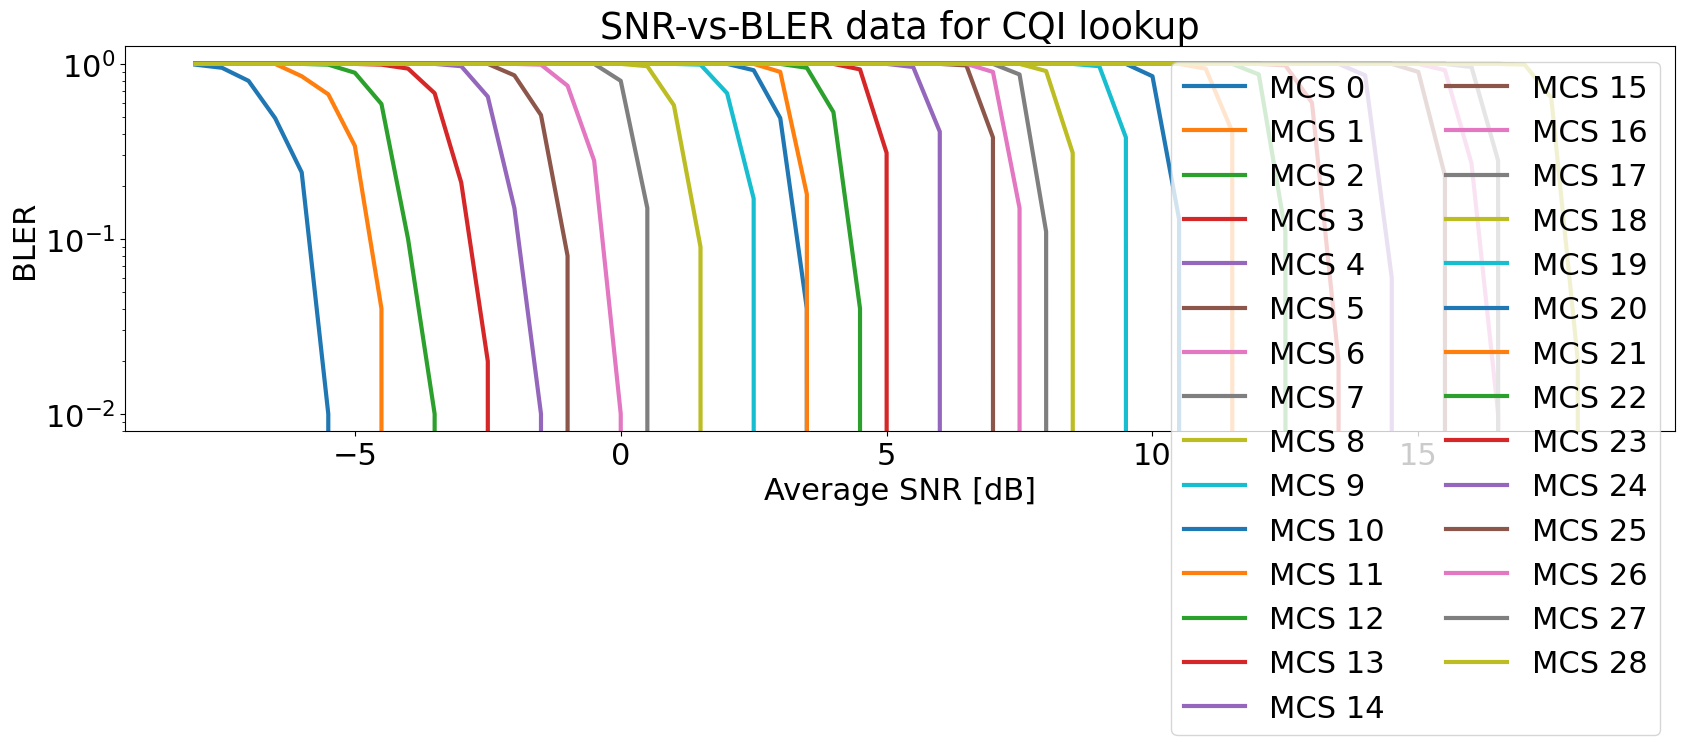

In [3]:
# Visualize the lookup data
plt.figure(figsize=[20,5])

legend = []
for i in range( nrof_rates ):
    plt.semilogy( snr_range_dB, snr_vs_bler[:,i] )
    legend.append('MCS %d'%(i))
    
plt.legend(legend, ncol=2)
plt.title('SNR-vs-BLER data for CQI lookup')
plt.xlabel('Average SNR [dB]')
plt.ylabel('BLER')

### Simulation parameters

In [4]:
# Standard-defined transport block sizes from [12, Tab. 7.1.7.2.1-1]
packet_sizes = [152, 200, 248, 320, 408, 504, 600, 712, 808, 936, 
                936, 1032, 1192, 1352, 1544, 1736, 1800, 
                1800, 1928, 2152, 2344, 2600, 2792, 2984, 3240, 3496, 3624, 3752, 4008]

# Standard-defined Modulation orders from [12, Tab. 7.1.7.1-1]
modorders    = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                4, 4, 4, 4, 4, 4, 4, 
                6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

# USER-DEFINED target BLER and OLLA parameters
target_bler = 0.1
olla_step_size = 0.1

# USER-DEFINED wireless channel configuration
norm_doppler = 0.01
avg_snr_dB = 15

# USER-DEFINED exbleriment parameters
# nrof_ttis = 50
# nrof_experiments = 10
nrof_ttis = 1000
nrof_experiments = 5

# Parameter settings for Figs. 1(a) and 1(b) in the paper:
#target_bler = 0.1
olla_step_size = 0.1
norm_doppler = 0.01
avg_snr_dB = 15
# nrof_ttis = 5000
# nrof_experiments = 1000

# Parameter settings for Figs. 1(c) and 1(d) in the paper:
#target_bler = 0.3
# olla_step_size = 0.1
# norm_doppler = 0.01
# avg_snr_dB = 15
# nrof_ttis = 5000
# nrof_experiments = 1000

### Extract prior BLER corresponding to each CQI value

In [5]:
from src.channel_quality_index import estimate_sinr_from_cqi, determine_bler_at_sinr

nrof_cqi = 16
bler_bler_cqi = np.ndarray( ( len( packet_sizes ), nrof_cqi ) )
for cqi in range( nrof_cqi ):
    snr_dB = estimate_sinr_from_cqi(cqi, awgn_data)
    bler_bler_cqi[ :, cqi ] = determine_bler_at_sinr(snr_dB, awgn_data)

### OLLA and BaysLA for link adaptation over a Rayleigh Fading channel

In [6]:
def run_experiment_for_agent(agent, nrof_ttis, channel_quality_indices, packet_acks, cqi_delay):
    """To disable CQI delay, set to zero."""
    rates = np.zeros(nrof_ttis)
    acks = np.zeros(nrof_ttis)
    tputs = np.zeros(nrof_ttis)

    for tti in range(nrof_ttis):
        # Optionally skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            selected_rate_index = np.random.randint(0, nrof_cqi)
            ack = packet_acks[tti, selected_rate_index]
        else:
            cqi = channel_quality_indices[tti - cqi_delay]  # may or may not be used depending on the agent
            selected_rate_index = agent.act(cqi)

            ack = packet_acks[tti, selected_rate_index]
            agent.update(selected_rate_index, cqi, ack)

        rates[tti] = selected_rate_index
        acks[tti] = ack
        tputs[tti] = packet_sizes[selected_rate_index] * ack
    
    return rates, acks, tputs

In [7]:
# RAY: The following method is packaged using Ray. To remove this dependence, comment out the line below.
# @ray.remote  # Comment this out if Ray is not used
def run_experiment( seed, nrof_ttis, avg_snr_dB, target_bler, olla_step_size, norm_doppler ):
    # pieces = 500
    # pieces = 10
    # piece_len = nrof_ttis // pieces
    
    #print('piece_len:' + piece_len)
    # error_stationary, cqi_stationary = simluate_rayleigh_fading_channel(nrof_ttis, 
    packet_error_probabilities, channel_quality_indices = simulate_rayleigh_fading_channel(nrof_ttis, 
                                                                        avg_snr_dB, 
                                                                        awgn_data, 
                                                                        packet_sizes, 
                                                                        norm_doppler,
                                                                        seed=seed)
    # error, CQI = simluate_rayleigh_fading_channel(piece_len, avg_snr_dB, awgn_data, packet_sizes, norm_doppler,
    #                                               seed=seed)
    # packet_error_probabilities = error
    # channel_quality_indices = CQI
    # for piece in range(1, pieces):
    #     avg_snr_dB = np.random.randint(5,30)
    #     norm_doppler = np.random.uniform(0, 0.5)
    #     error, CQI = simluate_rayleigh_fading_channel( piece_len, 
    #                                                   avg_snr_dB, 
    #                                                   awgn_data, 
    #                                                   packet_sizes, 
    #                                                   norm_doppler, 
    #                                                   seed = seed )

    #     packet_error_probabilities = np.vstack((packet_error_probabilities, error))
    #     channel_quality_indices = np.hstack((channel_quality_indices, CQI))
      
    #    print("SNR:%.2f"%avg_snr_dB)
    #    print("Doppler:%.2f"%norm_doppler)

#     # Visualize the packet error probabilities
#     plt.figure(figsize=[20,5])

#     legend = []
#     for i in range( nrof_rates ):
#         plt(packet_error_probabilities[:,i] )
#         legend.append('MCS %d'%(i))
    
#     plt.legend(legend, ncol=2)
#     plt.xlabel('t')
#     plt.ylabel('packet error probabilities')
    
#     # Visualize the channel quality indices
#     plt.figure(figsize=[20,5])

#     legend = []
#     for i in range( nrof_rates ):
#         plt(channel_quality_indices[:,i] )
#         legend.append('MCS %d'%(i))
    
#     plt.legend(legend, ncol=2)
#     plt.xlabel('t')
#     plt.ylabel('channel quality indices')
    
    # Pre-generate ACK events for all rates for all channel samples
    packet_acks = np.ndarray( ( nrof_ttis, nrof_rates ) )
    for tti in range( nrof_ttis ):
        for rate_index in range( nrof_rates ):
            packet_acks[tti, rate_index] = np.random.uniform( ) > packet_error_probabilities[tti, rate_index]

    cqi_delay = 0

    # Outer Loop Link Adaptation
    olla_bandit = OuterLoopLinkAdaptation(nrof_rates, nrof_cqi, packet_sizes, awgn_data, target_bler, olla_step_size)
    olla_rates, olla_acks, olla_tputs = run_experiment_for_agent(olla_bandit, nrof_ttis, channel_quality_indices, packet_acks, cqi_delay=0)

    # Thompson Sampling with Informed Priors
    bayesla_bandit = ThompsonSamplingBandit(nrof_rates, nrof_cqi, packet_sizes, target_bler, bler_bler_cqi)
    bayesla_rates, bayesla_acks, bayesla_tputs = run_experiment_for_agent(bayesla_bandit, nrof_ttis, channel_quality_indices, packet_acks, cqi_delay)

    # Tracking Thompson Sampling
    Trackbayesla_bandit = TrackingThompsonSamplingBandit(nrof_rates, nrof_cqi, packet_sizes, target_bler, bler_bler_cqi, discount=0.75)
    Trackbayesla_rates, Trackbayesla_acks, Trackbayesla_tputs = run_experiment_for_agent(Trackbayesla_bandit, nrof_ttis, channel_quality_indices, packet_acks, cqi_delay)

    # 20230530: added dTS for testing
    # actually dTS (discounted Thompson Sampling)
    dts_bandit = DiscountThompsonSamplingBandit(nrof_rates, packet_sizes, discount=0.75)
    dts_rates, dts_acks, dts_tputs = run_experiment_for_agent(dts_bandit, nrof_ttis, channel_quality_indices, packet_acks, cqi_delay)

    # Upper Confidence Bound (UCB1)
    ucb_bandit = UCB1Bandit(nrof_rates, nrof_cqi, packet_sizes, confidence_level=1.4, alpha=0.5)
    # D-UCB is buggy
    # ducb_bandit = DUCB1Bandit(nrof_rates, nrof_cqi, packet_sizes, confidence_level=1.4, alpha=0.5, gamma=0.75)
    ucb1_rates, ucb1_acks, ucb1_tputs = run_experiment_for_agent(ucb_bandit, nrof_ttis, channel_quality_indices, packet_acks, cqi_delay)
    
    return ( olla_rates, olla_acks, olla_tputs, 
             bayesla_rates, bayesla_acks, bayesla_tputs, 
             Trackbayesla_rates, Trackbayesla_acks, Trackbayesla_tputs, 
             dts_rates, dts_acks, dts_tputs,
             ucb1_rates, ucb1_acks, ucb1_tputs,
             packet_error_probabilities, channel_quality_indices)
            #  error_stationary, cqi_stationary)

### Run the experiments and collect results

In [8]:
olla_mcs = []
olla_ack = []
olla_tput = []

bayesla_mcs = []
bayesla_ack = []
bayesla_tput = []

Trackbayesla_mcs = []
Trackbayesla_ack = []
Trackbayesla_tput = []

dts_mcs = []
dts_ack = []
dts_tput = []

ucb1_mcs = []
ucb1_ack = []
ucb1_tput = []

# RAY: The following line runs the Ray-packaged method. To avoid using Ray, comment out the next line and uncomment
# the line that immediately follows it in order to run the experiments.
# results = ray.get( [ run_experiment.remote( i,
#                                             nrof_ttis, 
#                                             avg_snr_dB, 
#                                             target_bler,
#                                             olla_step_size,
#                                             norm_doppler ) for i in range(nrof_experiments) ] )

# RAY: uncomment the next line to run a single-threaded simulation that does not depend on Ray.
results = [ run_experiment( i, nrof_ttis, avg_snr_dB, target_bler, olla_step_size, norm_doppler ) for i in range(nrof_experiments) ]

In [9]:
# print(len(results[8]))
# print(len(bayesla_mcs))
# print(len(Trackbayesla_tput))
# print(len(packet_error_probabilities))
# print(len(channel_quality_indices))

### Extract the results in separate variables for OLLA and BayesLA

In [10]:
for res in results:
    olla_mcs.append( res[0] )
    olla_ack.append( res[1] )
    olla_tput.append( res[2] )
    
    bayesla_mcs.append( res[3] )
    bayesla_ack.append( res[4] )
    bayesla_tput.append( res[5] )
    
    Trackbayesla_mcs.append( res[6] )
    Trackbayesla_ack.append( res[7] )
    Trackbayesla_tput.append( res[8] )
    
    dts_mcs.append( res[9] )
    dts_ack.append( res[10] )
    dts_tput.append( res[11] )

    ucb1_mcs.append( res[12] )
    ucb1_ack.append( res[13] )
    ucb1_tput.append( res[14] )

In [11]:
# print(type(snr_vs_bler[:,1]))
# print(snr_vs_bler[:,1].size)
# print(type(snr_range_dB))
# print(snr_range_dB.size)

Text(0, 0.5, 'channel quality indices')

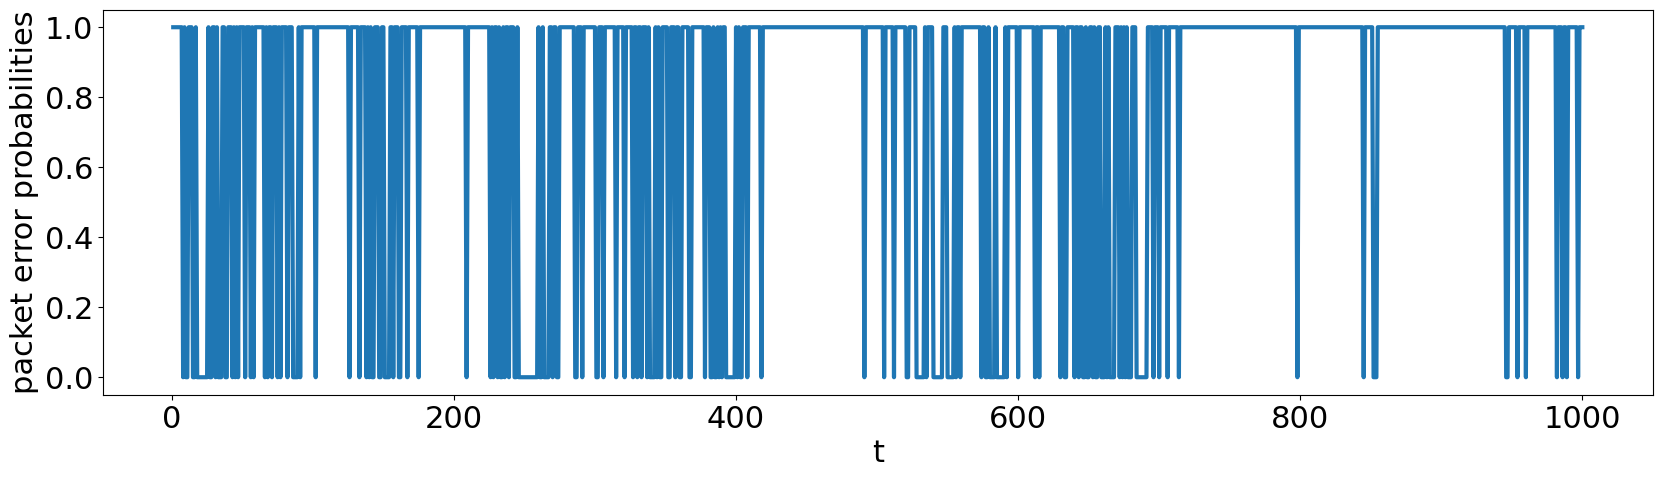

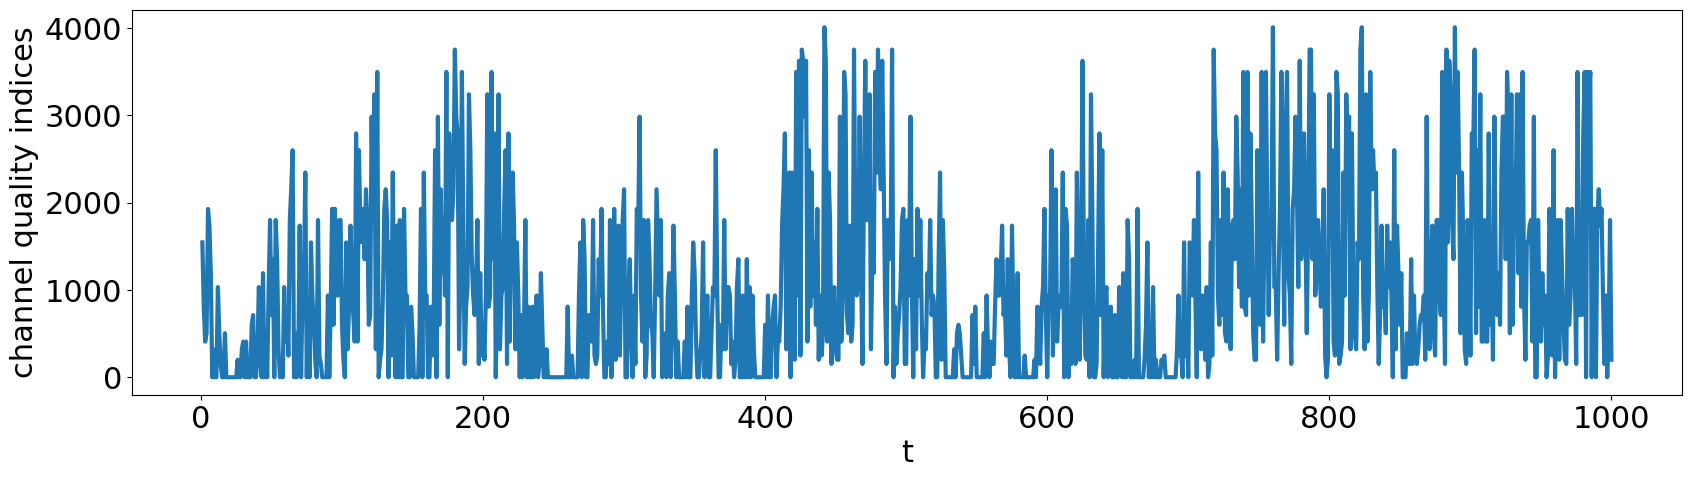

In [12]:
packet_error_probabilities = res[-4]
channel_quality_indices = res[-3]
error_stationary = res[-2]
cqi_stationary = res[-1]
# print(type(packet_error_probabilities[:,1]))
# print(packet_error_probabilities[:,1].size)
# list_error = packet_error_probabilities.tolist()
# list_cqi = channel_quality_indices.tolist()
# print(np.shape(list_error))

# Visualize the packet error probabilities

time_horizon = range(1, nrof_ttis + 1)
time_horizon = np.array(time_horizon)

plt.figure(figsize=[20,5])
# plt.plot(time_horizon, packet_error_probabilities[:,20])
plt.plot(time_horizon, packet_error_probabilities[:])
#plt.plot(time_horizon, error_stationary[:,20])

# legend = []
# for i in range( nrof_rates ):
#     plt.plot(time_horizon, packet_error_probabilities[:,i])
#     legend.append('MCS %d'%(i))    
# plt.legend(legend, ncol=2)

plt.xlabel('t')
plt.ylabel('packet error probabilities')
    
# Visualize the channel quality indices
plt.figure(figsize=[20,5])

plt.plot(time_horizon, channel_quality_indices)
# plt.plot(time_horizon, cqi_stationary)

plt.xlabel('t')
plt.ylabel('channel quality indices')

In [13]:
np.unique(packet_error_probabilities, return_counts=True)

(array([0., 1.]), array([228, 772]))

<BarContainer object of 50 artists>

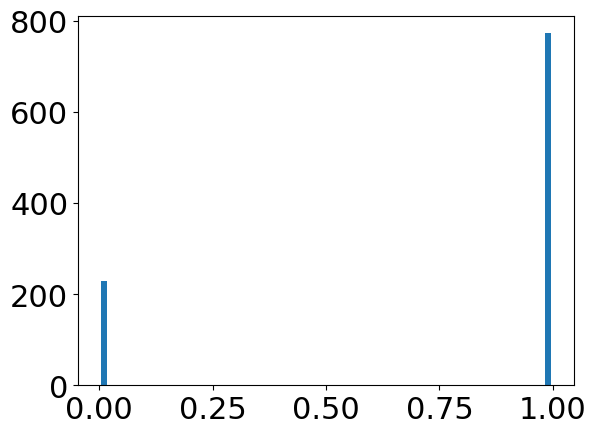

In [14]:
# hist_prob = np.unique(packet_error_probabilities, return_counts=True)
# plt.hist(x=hist_prob[1], bins=hist_prob[0])
counts, bins = np.histogram(packet_error_probabilities, 50)
# plt.stairs(counts, bins)
width = 0.7 * (bins[1] - bins[0])

center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, counts, width=width)

### Save the results to disk

In [15]:
data= { 'olla': ([], olla_ack, olla_tput),
        'bayesla': ([], bayesla_ack, bayesla_tput),
        'Trackbayesla': ([], Trackbayesla_ack, Trackbayesla_tput),
        'dts': ([], dts_ack, dts_tput),
        'ucb1': ([], ucb1_ack, ucb1_tput)}

In [16]:
#result_file = 'RESULT_SNR_%d_TARGET_%0.1f_DELAY_%d.npy'%( avg_snr_dB, target_bler, cqi_delay)

result_file = 'TEST_wei_nonstationary.npy'

np.save(result_file, data)

print('Saved to %s'%(result_file))

Saved to TEST_wei_nonstationary.npy
